# EE5104 Assigment 1 - CNN design, training and optimization
In this assignment, you will build and train a CNN from scratch using Tensorflow and Keras. You will then train your model on the ImageNette dataset (a subset of the ImageNet dataset with 10 relatively easy classes).

You will use Tensorboard to assess the performance of your model. In particular, you will examine the validation accuracy and validation loss.
You will also display the confusion matrix, precision, recall and F1 score for your model.

You will then use a selection of training optimization techniques to improve your model performance (again, validation accuracy and validation loss).

Finally, you will optimize your model with the TFLite toolbox, and compare the performance of your optimized model vs the original model

It is very highly recommended that you use Kaggle for this assignment, as Kaggle will give you 30 hours per week of GPU access for free, once you sign up. It is also very convenient for importing datasets.

## Assigment Details
- This assigment is worth 15% of your final grade.
- The submission deadline is Midnight, Sunday the 8th of February
- You will submit the notebook ipnb file via Canvas. Include all results, comments and discussion points within the notebook file

## Template notebook
You will be given a template notebook for this assignment. This template notebook includes:
- The libaries you'll need
- Instructions on how to add the ImageNette dataset
- Helper scripts for image pre-processing and dataset configuration
- Misc. instructions

## Kaggle setup
Open www.kaggle.com, and create an account. Once you create an account, verify with your phone number, and this will give you access to GPUs for training. You can do this by clicking on the account button in the top right of the Kaggle homepage. You can also see your GPU usage quota here.


## Import ImageNette Dataset
You can import the dataset we'll use for this assignment using either "File->Add Data", or via the menu on the right side of the Kaggle interface. - From the "Add Data" menu, search for "imagenette". There are a few versions, so select "Imagenette" uploaded by "asjad2024" (324mB). 

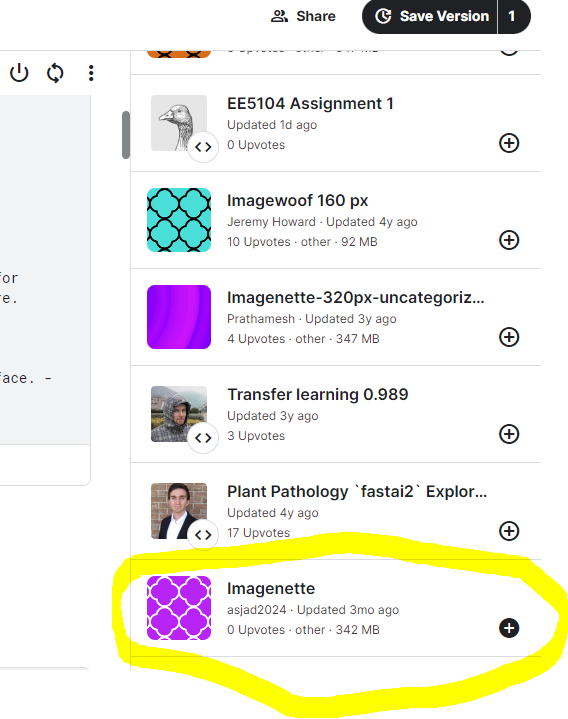

This will download the tarball containing the image data.

# WARNING!!!!!! files stored in the "Output" folder are not stored permanently! Download any model you want to keep if you want to avoid losing it!!!

## Import libraries we'll need
This is a complete list of all of the libraries you will need for this assignment

In [22]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models, layers, regularizers


from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint

# Helper libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm
import tarfile

# Some housekeeping libraries
from warnings import filterwarnings
import gc
import subprocess

## Dataset preparation
- Extract the tar file
- Define the folder locations


In [23]:
# defile the filepaths you'll be using
file_path = '/kaggle/input/imagenette/imagenette2-320.tgz'
output_path= '/kaggle/working'

# Open the tar.gz file
with tarfile.open(file_path,'r:*') as tar:
    # Extract all files
    tar.extractall(path=output_path)
    tar.close()

In [24]:
# define folder locations
train_dir = '/kaggle/working/imagenette2-320/train'
val_dir = '/kaggle/working/imagenette2-320/val'


## Label the data
If you explore the files you just extracted, you should see a train and val folder. Each contain subfolders with an alphanumeric name. These are the ImageNet labels for the objects. We need to define a dictionary to associate a human readible label with each of these alphanumeric names.

In [25]:
# create a dictionary to label the data
lbl_dict = dict(
    n01440764='tench',
    n02102040='English springer',
    n02979186='cassette player',
    n03000684='chain saw',
    n03028079='church',
    n03394916='French horn',
    n03417042='garbage truck',
    n03425413='gas pump',
    n03445777='golf ball',
    n03888257='parachute'
)

# we'll need a basic array later...
labels_array = np.array(list(lbl_dict.values()))

for key, value in lbl_dict.items():
    print(f"{key}: {value}")

n01440764: tench
n02102040: English springer
n02979186: cassette player
n03000684: chain saw
n03028079: church
n03394916: French horn
n03417042: garbage truck
n03425413: gas pump
n03445777: golf ball
n03888257: parachute


## Configuring the dataset
In the next section, we will configure the training and validation sets. 

We will also pre-process the images. To do this, we rescale the images to 224*224 pixels (standard for many object classifiers), and set the range from 0..1.0. 


In [26]:
# Set up arrays for train and val. "X" are the input images, "y" are the validation labels.
X_train = []
y_train = []

X_val = []
y_val = []

image_size = 224

for index, (key, value) in enumerate(lbl_dict.items()):
    folderPath = os.path.join('/kaggle/working/imagenette2-320','train', key)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size)).astype(np.float32)
        img /= 255.
        X_train.append(img)
        y_train.append(index)
        
for index, (key, value) in enumerate(lbl_dict.items()):
    folderPath = os.path.join('/kaggle/working/imagenette2-320','val',key)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size)).astype(np.float32)
        img /= 255.
        X_val.append(img)
        y_val.append(index)


        
X_train = np.array(X_train)
y_train = np.array(y_train)

X_val = np.array(X_val)
y_val = np.array(y_val)

# save a bit of ram
del img

100%|██████████| 390/390 [00:00<00:00, 675.15it/s]


## Set up one-hot encoding
So far, the y_train and y_val are set up as a single number from 0-9 (10 classes). We will now convert the flags to one-hot encoded i.e. class 2 = [0,0,1,0,0,0,0,0,0,0]

In [27]:
# perform one-hot encoding

y_train = tf.keras.utils.to_categorical(y_train)

y_val = tf.keras.utils.to_categorical(y_val)


## Create the classifier model.
Create a function that implements a basic CNN using Tensorflow and Keras. 

Define the input shape (224,224,3) and the number of classes = 10.

The starting network should have:
- an input layer with the same shape as the input image
- a convolution layer with 32 3x3 filters, a relu activation and same padding
- a max pooling layer with 2x2 pool size
- a convolution layer with 64 3x3 filters, relu activation and same padding
- a max pooling layer with 2x2 pool size
- a convolution layer with 128 3x3 filters, relu activation and same padding
- a max pooling layer with 2x2 pool size
- a Flatten layer
- a Dense later with 256 units and relu activation
- a Dense output layer with a softmax activation

Once the model is defined, create an instance of the classifier model and display the model summary


In [28]:
# define your classifier function here
def simpleClassifier(input_shape=(224, 224, 3), num_classes=10):

    # Define the model
    model = models.Sequential()
    
    # Input Layer
    model.add(layers.Input(shape=input_shape))
    
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))  # Output layer
    
    return model

# Create an instance of the model
model = simpleClassifier()

# Display model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │      25,690,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,786,186 (98.37 MB)

 Trainable params: 25,786,186 (98.37 MB)

 Non-trainable params: 0 (0.00 B)

## Create a tensorboard to track model learning
Tensorboards are very useful for tracking model training. For more details, check out https://zito-relova.medium.com/tensorboard-tutorial-5d482d270f08
 and https://www.kaggle.com/code/aagundez/using-tensorboard-in-kaggle-kernels. We will also create a ModelCheckpoint to save the best version of the model.
 
 Note: there seem to be issues with Kaggle and Tensorboard, so for now, we will just plot the output inline with a function defined below.

In [29]:
# load tensorboard
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("simpleClassifier.keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)


## Configure and train the model
In this block, we will do the following:
- Configure the learning rate using "ReduceLROnPlateau" finction, to reduce the learning rate when we get closer to model convergence
- Compile the model. Use categorical_crossentropy loss, the Adam optimizer, and accuracy as the metrics
- Fit the model to the training data with the model.fit function. Explicitly set the validation data to (X_val, y_val). For now, set train for 15 epochs with a batch size of 32


In [30]:
#define the learning rate using ReduceLRONPlateau function
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

#Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#Display the model architecture
model.summary()

#Train the model
history = model.fit(
    X_train,               
    y_train,               
    batch_size=32,        
    epochs=15,             
    validation_data=(X_val, y_val),  
    callbacks=[reduce_lr]   
)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │      25,690,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,786,186 (98.37 MB)

 Trainable params: 25,786,186 (98.37 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
296/296 ━━━━━━━━━━━━━━━━━━━━ 30s 92ms/step - accuracy: 0.3353 - loss: 2.0322 - val_accuracy: 0.5338 - val_loss: 1.4015 - learning_rate: 0.0010
Epoch 2/15
296/296 ━━━━━━━━━━━━━━━━━━━━ 17s 59ms/step - accuracy: 0.6631 - loss: 1.0226 - val_accuracy: 0.6375 - val_loss: 1.1136 - learning_rate: 0.0010
Epoch 3/15
296/296 ━━━━━━━━━━━━━━━━━━━━ 17s 59ms/step - accuracy: 0.7760 - loss: 0.6784 - val_accuracy: 0.6555 - val_loss: 1.1516 - learning_rate: 0.0010
Epoch 4/15
296/296 ━━━━━━━━━━━━━━━━━━━━ 17s 59ms/step - accuracy: 0.9053 - loss: 0.3161 - val_accuracy: 0.6400 - val_loss: 1.4233 - learning_rate: 0.0010
Epoch 5/15
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9697 - loss: 0.1089
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
296/296 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step - accuracy: 0.9697 - loss: 0.1090 - val_accuracy: 0.6515 - val_loss: 1.6564 - learning_rate: 0.0010
Epoch 6/15
296/296 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step - accuracy: 0.9928 - lo

## View the training results
You can check the training progress in realtime by going to localhost:6006 (in principle, seems to be an issue with Kaggle)

We will also set up a helper function below to plot the training results inline

In [31]:
# function to plot your training results
def plot_results(history, epochs):
    filterwarnings('ignore')

    epochs = [i for i in range(epochs)]
    fig, ax = plt.subplots(1,2,figsize=(14,7))
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
                 fontname='monospace',y=1,x=0.28,alpha=0.8)

    sns.despine()
    ax[0].plot(epochs, train_acc, marker='o',
               label = 'Training Accuracy')
    ax[0].plot(epochs, val_acc, marker='o',
               label = 'Validation Accuracy')
    ax[0].legend(frameon=False)
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')

    sns.despine()
    ax[1].plot(epochs, train_loss, marker='o',
               label ='Training Loss')
    ax[1].plot(epochs, val_loss, marker='o',
               label = 'Validation Loss')
    ax[1].legend(frameon=False)
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Training & Validation Loss')

    fig.show()

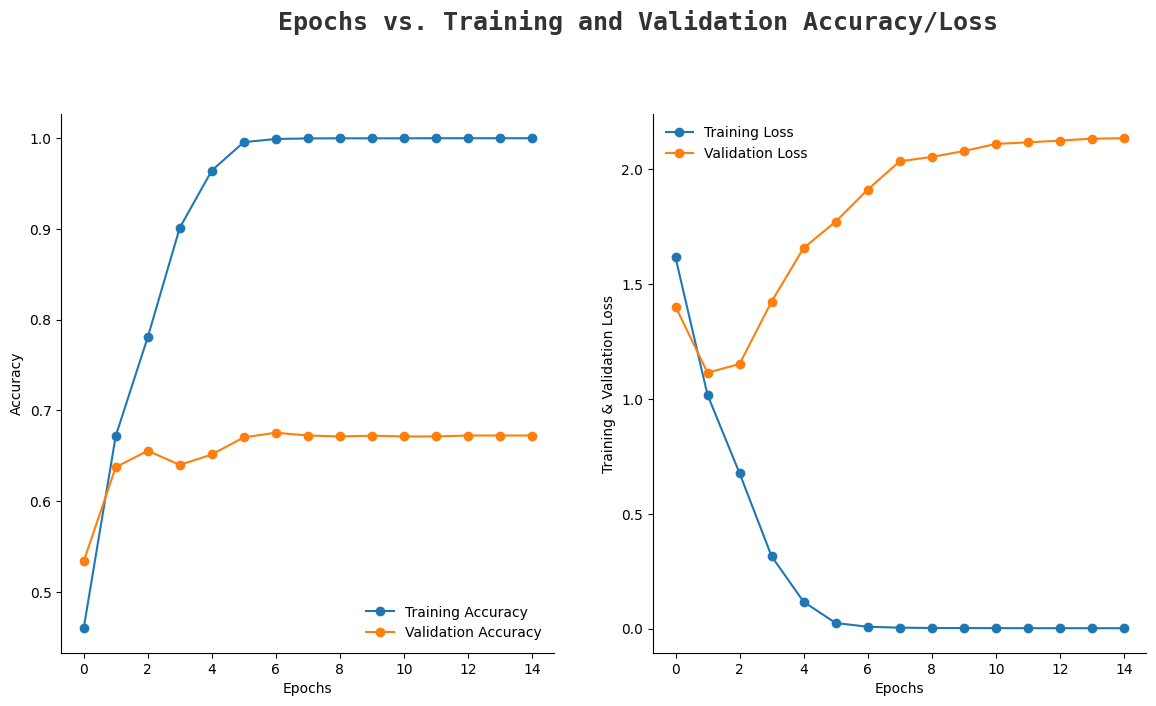

In [32]:
# plot the results
plot_results(history,epochs=15)

## Comment on the results from the simple classifier
The plots above show clear signs of overfitting:   
__Training vs Validation accuracy__
- The training accuracy in the plot above plateaus at around 100%. This sugeests that it is learning the training set too much and learning its noise aswell as its genuine patterns.
- Validation accuracy plateaus at 60% which is very poor performance on unseen data which suggests that the model is learning the training data too much and not generalising very well.
- The big gap between training data and testing data is a clear indicator of overfitting in the training process.

__Loss Curve Analysis__
- Training loss continuously decreases approaching zero
- Validation loss initially decreases and starts increasing significantly after two epochs.
- This diverging nature of the loss curves suggests overfitting also.

Considering both of the plots above and the above anlysis of the results it is clear the model is overfitting to the training data which is hindering its accuracy and performance on unseen data. 

## Comments on training performance
The models training performance there is a few concepts that are noteworthy: 
- The initial training process is rapid with good perfomance being shown in the first 2-3 epochs. Accuracy in training and validation is increasing and the loss functions in both datasets are decreasing.
- The optimisation process was stable, showing smooth curves without major oscillations
- Training continued for too many epochs with the model showing signs of overfitting after epoch 3 and the trianing continued till epoch 14.
- The learning process was too aggressive reaching near perfect training accuracy too quickly.
- A way to improve this would be too slow down the learning rate and bring in regularisation or early stopping into the training process which would slow the the learning process and allow it to better gather the patterns in the data. 

## Precision and recall
__ Best Performing Class__
- Class 9 (parachute) is the best-performing class with a precision of 77% and a good recall of 73%. This ultimately leads to the best F1 score of 75%
Class 0 (Bench) also performs strongly, with precision of 72% and recall of 73%, leading to an F1 Score of 73%.

__Poorest Performing Algorithms__
- The two worst-performing classes are class 3 and class 7.
- Class 3 receives a precision of 44% and a recall of 42% giving it the lowest F1 score of 43%.
- Class 7 has a weak performance with a precision of 57% and a recall of 47% the poor recall leads to a poor F1-score of 51%

 __Overall model performance__
- Consistent average metrics with precision, recall and F1-score all being around the same figure of 64%.
- Support values show balanced class distribution (ranging from 357-419 samples per class)

The confusion matrix confirms these metrics with:
- Strong diagonal values for well-performing classes
- More off-diagonal elements for poorly performing classes
- Relatively balanced support across all classes

123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
              precision    recall  f1-score   support

           0       0.73      0.76      0.75       387
           1       0.69      0.76      0.72       395
           2       0.67      0.71      0.69       357
           3       0.51      0.48      0.50       386
           4       0.71      0.73      0.72       409
           5       0.69      0.64      0.66       394
           6       0.69      0.75      0.72       389
           7       0.61      0.53      0.57       419
           8       0.64      0.64      0.64       399
           9       0.76      0.73      0.74       390

    accuracy                           0.67      3925
   macro avg       0.67      0.67      0.67      3925
weighted avg       0.67      0.67      0.67      3925



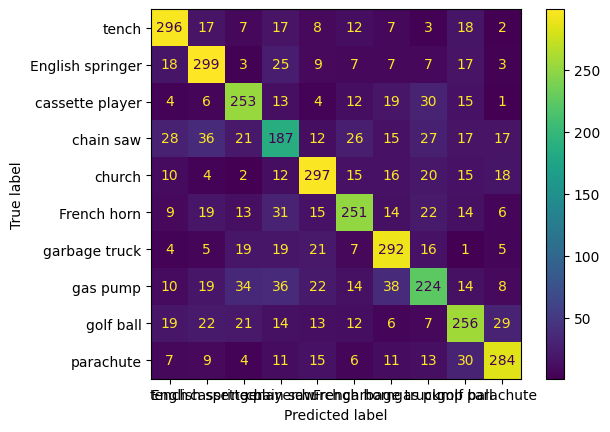

<Figure size 2000x2000 with 0 Axes>

In [33]:
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay


pred = model.predict(X_val)
pred = np.argmax(pred,axis=1)
y_val_new = np.argmax(y_val,axis=1)


print(classification_report(y_val_new,pred))

cm = confusion_matrix(y_val_new,pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_array)
disp.plot()
plt.figure(figsize=(20, 20))
plt.show()


## Clean up
Before we run the next model, we need to clean up the workspace, particularly to free up some RAM. The code snippet below will do this.

In [48]:
def clean_up(model=improved_model):
    #delete the model
    del model

    # Clear TensorFlow session
    tf.keras.backend.clear_session()

    # Force garbage collection
    gc.collect()

In [54]:
clean_up(model=improved_model)

## Optimize model performance
Without changing the number of epochs, modify the network to improve validation loss and accuracy. There are a number of ways to do this, including data augmentation, dropout, batch normalization, L1/L2 regularization etc. Experiment with these options and save your best performing result.

In [53]:
def improvedClassifier(input_shape=(224, 224, 3), num_classes=10):
    # Define the model
    model = models.Sequential([

        layers.Input(shape=input_shape),

        layers.Resizing(160, 160),

        layers.Conv2D(32, (3, 3), padding='same',
                     kernel_regularizer=regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.35),
        
        layers.Conv2D(64, (3, 3), padding='same',
                     kernel_regularizer=regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),
        
        
        layers.Conv2D(128, (3, 3), padding='same',
                     kernel_regularizer=regularizers.l2( l2=0.01)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.45),
        
        layers.Flatten(),
        
        layers.Dense(256, kernel_regularizer=regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.5),
        
        # Output Layer
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

improved_model = improvedClassifier()

improved_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing_4 (Resizing)                │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 160, 160, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 160, 160, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_16 (Activation)           │ (None, 160, 160, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 80, 80, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 80, 80, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 80, 80, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 80, 80, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_17 (Activation)           │ (None, 80, 80, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 40, 40, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 40, 40, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 40, 40, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 40, 40, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_18 (Activation)           │ (None, 40, 40, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │      13,107,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 13,205,194 (50.37 MB)

 Trainable params: 13,204,234 (50.37 MB)

 Non-trainable params: 960 (3.75 KB)

In [46]:
# set up a tensorboard and save logs
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("improvedClassifier.keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)


In [55]:
lr_reducer = ReduceLROnPlateau(
    monitor='val_loss',    
    factor=0.2,
    patience=3,         
    min_lr=1e-6,        
    verbose=1, 
    min_delta=0.01
)

# Compile the model
improved_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = improved_model.fit(
    X_train,               
    y_train,               
    batch_size=32,        
    epochs=15,            
    validation_data=(X_val, y_val),  
    callbacks=[lr_reducer]   
)

improved_model.save('/kaggle/working/improvedClassifier.keras')


Epoch 1/15
296/296 ━━━━━━━━━━━━━━━━━━━━ 37s 102ms/step - accuracy: 0.3599 - loss: 9.1709 - val_accuracy: 0.2308 - val_loss: 6.4502 - learning_rate: 0.0010
Epoch 2/15
296/296 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.5232 - loss: 4.5244 - val_accuracy: 0.3162 - val_loss: 5.1082 - learning_rate: 0.0010
Epoch 3/15
296/296 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.5782 - loss: 4.1139 - val_accuracy: 0.5228 - val_loss: 4.1988 - learning_rate: 0.0010
Epoch 4/15
296/296 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.5932 - loss: 4.1047 - val_accuracy: 0.4907 - val_loss: 4.4242 - learning_rate: 0.0010
Epoch 5/15
296/296 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.5915 - loss: 4.1324 - val_accuracy: 0.3210 - val_loss: 5.6160 - learning_rate: 0.0010
Epoch 6/15
295/296 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6173 - loss: 4.0852
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
296/296 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.6172 - l

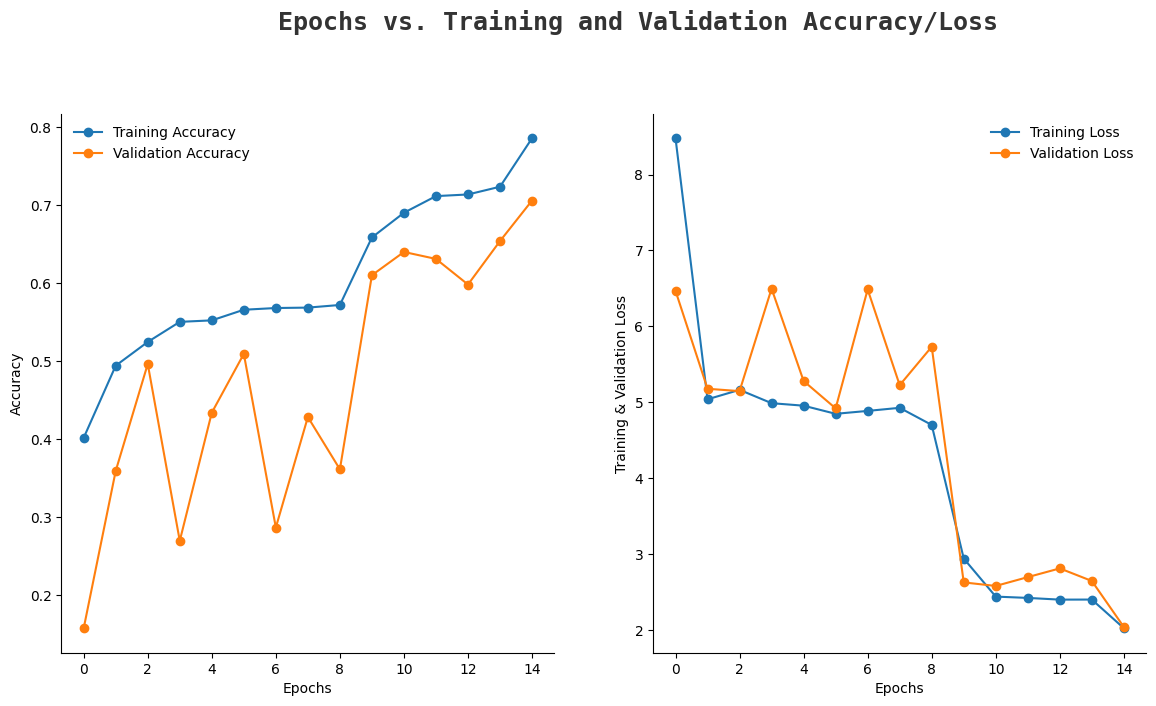

In [39]:
plot_results(history,epochs=15)

## Implement an optimized model
When applying our model to embedded/edge devices, it is important to optimize the model i.e. smaller, faster inference on edge devices. To do this, we can use the converter function from the tensorflow TFLite library.

In this section, you will take your best model, and convert it to a TFLite model. Follow this guideline https://www.kaggle.com/code/ashusma/understanding-tf-lite-and-model-optimization

Apply post-training quantization to reduce the size of your model. Also, export your model as a concrete function (see guide for details)

Note: Configure the model as a float16 implementation, as the Jetson Nano is a float16 processor.

When finished, save your output model.

Comment on the model size and performance trade-offs of the optimized model vs the original model

In [56]:
# Simple direct conversion from saved model
model = tf.keras.models.load_model('/kaggle/working/improvedClassifier.keras')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

Saved artifact at '/tmp/tmp62yox_si'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  137502233278096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137503338095792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137502182035824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137503316227024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137505078794672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137502129276000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137502176569024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137502175020480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137502228952896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137502175024000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137502175020

In [57]:
# Load model
model = tf.keras.models.load_model('/kaggle/working/improvedClassifier.keras')

# Convert to concrete function
concrete_func = tf.function(model).get_concrete_function(
    tf.TensorSpec([1, 224, 224, 3], tf.float32))

#Create converter from concrete function
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])

#Configure float16 quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

# Convert and save
tflite_model = converter.convert()
with open('model_float16.tflite', 'wb') as f:
    f.write(tflite_model)

In [58]:
# helper function to evaluate tflite model on the test dataset

def eval_model(interpreter, X_val, y_val):
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    
    num_correct = 0

    # Run predictions on every image in the "test" dataset.
    prediction_digits = []
    for i, test_image in enumerate(X_val):
        if i % 1000 == 0:
            print(f'Evaluated on {i} results so far.')

        # Pre-processing: add batch dimension and convert to float32 to match with
        # the model's input data format.
        input_data = test_image.reshape((1, 224, 224, 3))
        test_image_f32 = tf.dtypes.cast(input_data, tf.float32)
        interpreter.set_tensor(input_index, test_image_f32)

        # Run inference.
        interpreter.invoke()

        # Post-processing: remove batch dimension and find the digit with highest
        # probability.
        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])  # Get predicted class index
        prediction_digits.append(digit)

        # Compare with ground truth (converted from one-hot encoding)
        if digit == np.argmax(y_val[i]):  
            num_correct += 1

    # Convert predictions to numpy array (optional)
    prediction_digits = np.array(prediction_digits)

    # Return accuracy
    return num_correct / len(X_val)

In [59]:
# run the helper function to test the accuracy
interpreter = tf.lite.Interpreter(model_path="/kaggle/working/model_float16.tflite")
interpreter.allocate_tensors()

test_accuracy = eval_model(interpreter, X_val, y_val)

print('Optimized model test accuracy:', test_accuracy)

Evaluated on 0 results so far.
Evaluated on 1000 results so far.
Evaluated on 2000 results so far.
Evaluated on 3000 results so far.
Optimized model test accuracy: 0.726624203821656


## Comment on the performance of the optimized model
Compare the performance of your optimized model vs the baseline model in terms of accuracy and model size. Comment on the benefits of model optimization for edge devices and embedded systems

- The optimised model has a much better performance compared to the simplified model with a accuracy of 74% and a loss of 1.64. This clearly outperforms the simplified model.
- The params in the simple classifier is 25,786,186 and this is dropped to 13,205,194 for the optimised model this is mainly due to the resizing at the start of the model architecture which cuts the images in half.
- Considering there is that much drop in the params this would really improve the performance of the model on an embedded device considering memory size and processing power is the limiting factor to the performance. So having the params cut in half with an increase in performance would be very good for performance.
- Also then converting the model to a tflite format with 16 bit float values will give the model better performnce as the model has to process numbers with half the number of bits compared to the unoptimised model.
- It would be interesting to measure the impact on accuracy and perfoermance if it is optimised to int values or smaller floating opoint values.  
__Optimising the model__
- When optimising the model I started by adding all the optimisation techniques into the model and testing their effects.
- Concluded that L1 regularisation had no effect on the performance so removed it from the model architecture.
- I then ran into problems with the augmentation layers when converting to TFLite so removed it and found no major performance issues.
- I then got good performance with the model using the default normalisation values, dropout and L2 regularisation but the model was overfitted.
- My inital solution to this problem was to increase the dropout in order to make the model have a more even training accuracy and validation accuracy.
- This caused better performance with no overfitting but the dropout was raised to 80% in the final layers which is ineffective in terms of using all of the data and also the models accuracy increased quickly and plateaud with the high dropout.
- To try improve the performance I troubleshooted the augmentation issues and found that resizing brought slower more steady accuracy increase and I increased the L2 regularisation from .001 to .08 which promotes a quicker learning rate encouraging bigger weights while training.
- The augmentation made it harder for the model to learn however this countered with the increase in regularisation casued the model to learn at a more gradual pace reaching its maximum after 10 epochs and the possibility for it to continue to increase after 15 epochs. 
- The performance is good in the above model however at around the 5th epoch there is a big dropoff in performance which is not ideal and learning could be a little bit more consistent rather than having instable accuracy curves. 